# 1 特征工程优化

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV
from scipy import stats

# 加载已预处理的数据
df = pd.read_csv('../datasets/walmart_preprocessed.csv')
print("使用原始预处理数据中的特征...")
print(f"原始特征数量: {df.shape[1]}")

使用原始预处理数据中的特征...
原始特征数量: 20


In [2]:
# 1. 基于EDA添加更有针对性的交互特征
# 只保留经验证有价值的交互特征
df['Age_City'] = df['Age'].astype(str) + "_" + df['City_Category']
df['Gender_Marital'] = df['Gender'] + "_" + df['Marital_Status'].astype(str)

# 2. 改进的RFM分析
# R(Recency)：停留年限的对数转换，更好地处理长尾分布
df['Recency_Score'] = 5 - df['Stay_Years'] 
df['Recency_Log'] = np.log1p(df['Recency_Score'])

# F(Frequency)：购买频次的分段和对数转换
df['Frequency_Score'] = pd.qcut(df['Purchase_Count'], 5, labels=[1, 2, 3, 4, 5])
df['Frequency_Log'] = np.log1p(df['Purchase_Count'])

# M(Monetary)：使用分位数而不是等距分箱，更好地处理异常值
df['Monetary_Score'] = pd.qcut(df['Total_User_Purchase'], 5, labels=[1, 2, 3, 4, 5])
df['Monetary_Log'] = np.log1p(df['Total_User_Purchase'])

# RFM分数 - 使用数值特征而非字符串连接，方便模型处理
df['RFM_Total'] = df['Recency_Score'].astype(int) + df['Frequency_Score'].astype(int) + df['Monetary_Score'].astype(int)

# 3. 处理偏态分布特征
# 对高度偏斜的数值特征应用对数转换
skewed_features = ['Product_Purchase_Var', 'Avg_Transaction_Value', 'Total_User_Purchase']
for col in skewed_features:
    if col in df.columns:
        df[f'{col}_log'] = np.log1p(df[col])

# 4. 更有针对性的特征组合
# 产品类别和用户消费水平的交互
user_spending_level = pd.qcut(df['Total_User_Purchase'], 3, labels=['低', '中', '高']).astype(str)  # 转换为字符串类型
df['Product_Spending'] = df['Product_Category'].astype(str) + "_" + user_spending_level

# 5. 特征分箱 - 将连续特征转换为分类特征
df['Occupation_Bin'] = pd.cut(df['Occupation'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# 6. 比率特征 - 捕捉相对关系
df['Purchase_Frequency_Ratio'] = df['Purchase_Count'] / (df['Stay_Years'] + 1)  # 避免除以0

# 7. 使用更高级的多项式特征 - 仅选择关键变量
df['Purchase_Count_Sq'] = df['Purchase_Count'] ** 2
df['Stay_Years_Sq'] = df['Stay_Years'] ** 2

# 8. 目标编码 - 替换原始分类特征，使用交叉验证方式避免泄露
from sklearn.model_selection import KFold

# 为目标编码创建交叉验证折叠
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for cat in ['City_Category', 'Age']:
    # 创建新的编码列
    df[f'{cat}_target_mean'] = np.nan
    df[f'{cat}_target_var'] = np.nan
    
    # 对每个折叠进行编码
    for train_idx, test_idx in kf.split(df):
        # 使用训练集计算编码
        train_means = df.iloc[train_idx].groupby(cat)['Purchase'].mean()
        train_vars = df.iloc[train_idx].groupby(cat)['Purchase'].var().fillna(0)
        
        # 应用到测试集
        for cat_value, mean_val in train_means.items():
            mask = (df.iloc[test_idx][cat] == cat_value)
            df.loc[df.index[test_idx][mask], f'{cat}_target_mean'] = mean_val
            
        for cat_value, var_val in train_vars.items():
            mask = (df.iloc[test_idx][cat] == cat_value)
            df.loc[df.index[test_idx][mask], f'{cat}_target_var'] = var_val

In [3]:
# 准备最终特征集
categorical_features = [
    'Gender', 'Age', 'City_Category', 'Marital_Status', 
    'Gender_Marital', 'Age_City', 'Product_Spending', 'Occupation_Bin'
]

numerical_features = [
    'Occupation', 'Stay_Years', 'Product_Category', 'City_Code', 
    'Gender_Code', 'Total_User_Purchase', 'Purchase_Count',
    'Avg_User_Purchase', 'Avg_Category_Purchase', 
    'Monetary_Log', 'Frequency_Log', 'Recency_Log',
    'RFM_Total', 'Purchase_Frequency_Ratio', 'Avg_Purchase_Ratio',
    'City_Category_target_mean', 'Age_target_mean'
]

# 2 特征选择

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

# 准备X和y，确保不包含特征泄露
target = 'Purchase'
columns_to_drop = ['Purchase']
if 'Purchase_Log' in df.columns:
    columns_to_drop.append('Purchase_Log')
    
# 移除任何可能包含目标变量的特征
if 'Avg_Purchase_Ratio' in df.columns:
    columns_to_drop.append('Avg_Purchase_Ratio')
if 'Avg_Purchase_Ratio_Squared' in df.columns:
    columns_to_drop.append('Avg_Purchase_Ratio_Squared')
if 'Avg_Purchase_Ratio_Log' in df.columns:
    columns_to_drop.append('Avg_Purchase_Ratio_Log')
if 'Avg_User_Purchase_X_Ratio' in df.columns:
    columns_to_drop.append('Avg_User_Purchase_X_Ratio')

X = df.drop(columns_to_drop, axis=1)
y = df[target]

# 去除不需要的列 - 使用更安全的方式
cols_to_drop = ['User_ID', 'Product_ID', 'Stay_In_Current_City_Years', 
               'Purchase_Normalized', 'Purchase_Standardized', 'Age_Category']

# 只删除存在的列
existing_cols_to_drop = [col for col in cols_to_drop if col in X.columns]
X = X.drop(existing_cols_to_drop, axis=1)

# 显示保留的特征数量
print(f"特征准备完成，保留了{X.shape[1]}个特征")

# 分割数据 - 使用分层抽样保持分布
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

特征准备完成，保留了32个特征


In [5]:
# 预处理管道
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', PowerTransformer(method='yeo-johnson'))  # 使用更适合处理偏态分布的转换器
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 构建预处理器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [col for col in numerical_features if col in X.columns]),
        ('cat', categorical_transformer, [col for col in categorical_features if col in X.columns])
    ])

# 应用预处理
preprocessed_X_train = preprocessor.fit_transform(X_train)
preprocessed_X_test = preprocessor.transform(X_test)

In [9]:
# 采样数据以加速
sample_size = min(5000, preprocessed_X_train.shape[0])
indices = np.random.choice(preprocessed_X_train.shape[0], sample_size, replace=False)
X_sample = preprocessed_X_train[indices]
y_sample = y_train.iloc[indices]

# 处理特征名称 - 检查是否为稀疏矩阵
import scipy.sparse as sp
if sp.issparse(preprocessed_X_train):
    # 如果是稀疏矩阵，创建数值索引作为特征名称
    n_features = preprocessed_X_train.shape[1]
    feature_names = [f"feature_{i}" for i in range(n_features)]
else:
    # 如果是DataFrame，获取列名
    feature_names = preprocessed_X_train.columns.tolist()

print(f"特征数量: {len(feature_names)}")

# 使用轻量级随机森林
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=20,  # 减少树的数量
    max_depth=10,     # 限制树的深度
    n_jobs=-1,        # 使用所有核心
    random_state=42
)
rf.fit(X_sample, y_sample)

# 获取特征重要性
importances = rf.feature_importances_
indices_sorted = np.argsort(importances)[::-1]

# 选择前N个特征
N = min(20, len(feature_names))
top_features = [feature_names[i] for i in indices_sorted[:N]]

# 打印顶部特征
print("Top 20 特征:")
for i, feature in enumerate(top_features):
    print(f"{i+1}. {feature} ({importances[indices_sorted[i]]:.4f})")

特征数量: 120
Top 20 特征:
1. feature_8 (0.7656)
2. feature_7 (0.0839)
3. feature_13 (0.0180)
4. feature_15 (0.0151)
5. feature_2 (0.0119)
6. feature_0 (0.0114)
7. feature_5 (0.0083)
8. feature_9 (0.0083)
9. feature_10 (0.0076)
10. feature_6 (0.0067)
11. feature_12 (0.0053)
12. feature_11 (0.0034)
13. feature_1 (0.0031)
14. feature_31 (0.0026)
15. feature_35 (0.0025)
16. feature_32 (0.0022)
17. feature_44 (0.0020)
18. feature_86 (0.0019)
19. feature_116 (0.0019)
20. feature_41 (0.0018)


In [10]:
# 方法2：使用统计方法 - 互信息（非常快速）
print("\n\n使用互信息法评估特征...")
from sklearn.feature_selection import mutual_info_regression

# 计算互信息
mi_scores = mutual_info_regression(X_sample, y_sample, random_state=42)
mi_indices = np.argsort(mi_scores)[::-1]

# 选择前N个特征
mi_top_features = [feature_names[i] for i in mi_indices[:N]]
print(f"\n互信息选择的前{N}个特征:")
for i, feature in enumerate(mi_top_features):
    print(f"{i+1}. {feature} (MI分数: {mi_scores[mi_indices[i]]:.4f})")



使用互信息法评估特征...

互信息选择的前20个特征:
1. feature_2 (MI分数: 1.6217)
2. feature_8 (MI分数: 1.6217)
3. feature_102 (MI分数: 0.1313)
4. feature_85 (MI分数: 0.1308)
5. feature_100 (MI分数: 0.1259)
6. feature_101 (MI分数: 0.1137)
7. feature_86 (MI分数: 0.1107)
8. feature_110 (MI分数: 0.1034)
9. feature_109 (MI分数: 0.0985)
10. feature_111 (MI分数: 0.0932)
11. feature_87 (MI分数: 0.0919)
12. feature_7 (MI分数: 0.0736)
13. feature_9 (MI分数: 0.0729)
14. feature_5 (MI分数: 0.0729)
15. feature_60 (MI分数: 0.0482)
16. feature_93 (MI分数: 0.0363)
17. feature_59 (MI分数: 0.0346)
18. feature_95 (MI分数: 0.0332)
19. feature_94 (MI分数: 0.0330)
20. feature_6 (MI分数: 0.0323)


In [11]:
# 方法3：结合两种方法的结果
combined_features = list(set(top_features) | set(mi_top_features))
print(f"\n两种方法结合后的特征集 ({len(combined_features)}个特征):")
print(combined_features)


两种方法结合后的特征集 (33个特征):
['feature_15', 'feature_100', 'feature_59', 'feature_11', 'feature_35', 'feature_2', 'feature_41', 'feature_8', 'feature_110', 'feature_32', 'feature_85', 'feature_102', 'feature_9', 'feature_116', 'feature_101', 'feature_31', 'feature_0', 'feature_44', 'feature_12', 'feature_87', 'feature_86', 'feature_10', 'feature_95', 'feature_94', 'feature_111', 'feature_60', 'feature_5', 'feature_93', 'feature_109', 'feature_1', 'feature_13', 'feature_7', 'feature_6']


In [12]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'SimHei'  # 或其他支持中文的字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题


重要性大于0.001的特征数量: 30


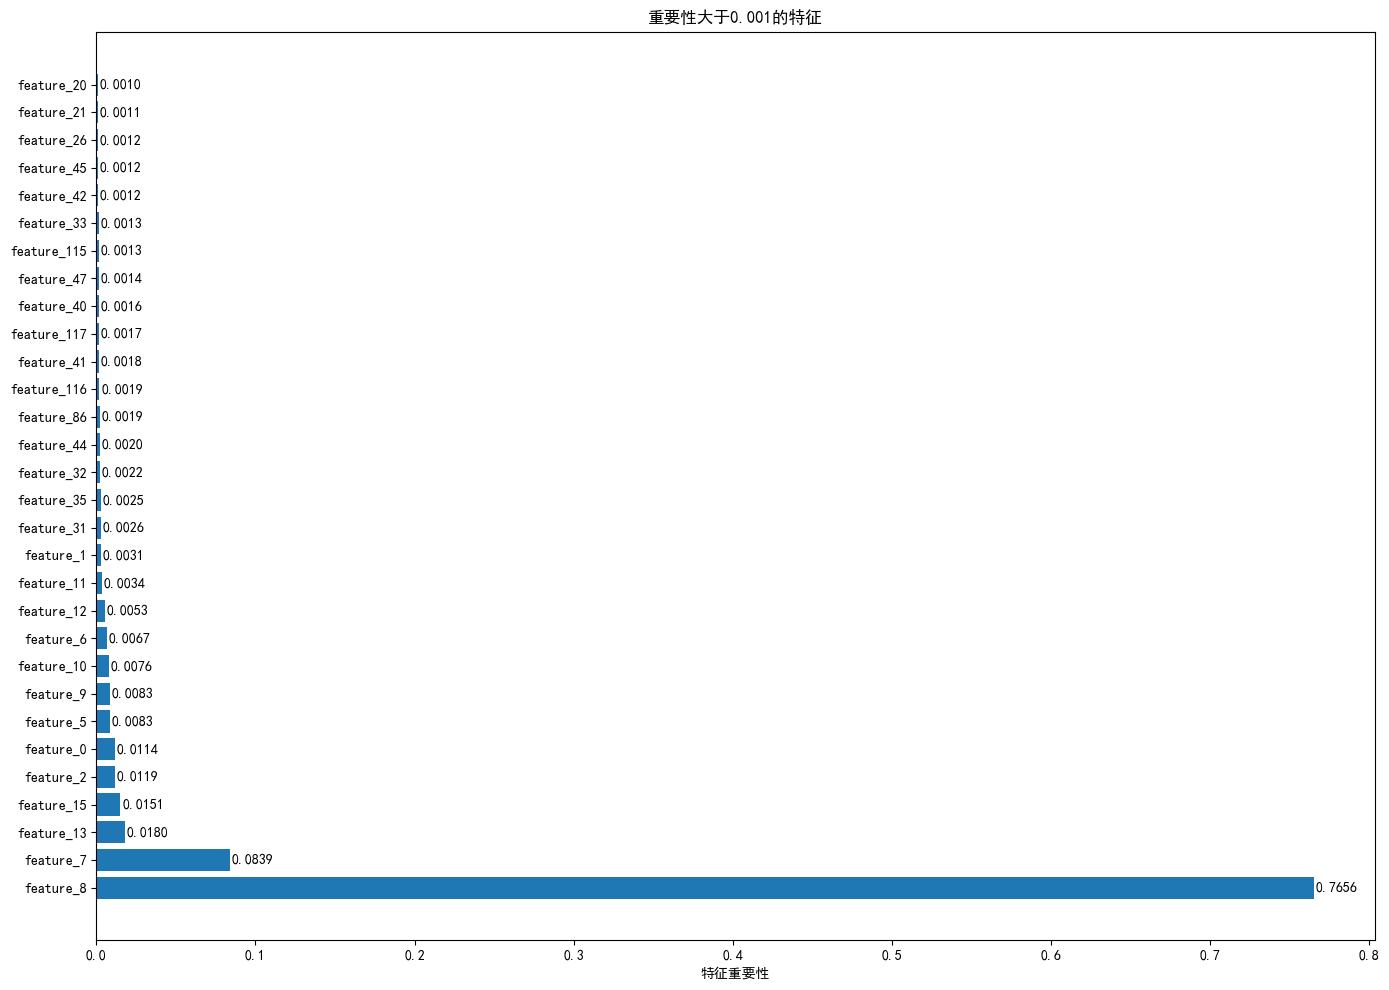

In [13]:
threshold = 0.001  # 设置一个合理的阈值
significant_indices = [i for i in indices_sorted if importances[i] > threshold]
significant_features = [feature_names[i] for i in significant_indices]
significant_importances = [importances[i] for i in significant_indices]

print(f"\n重要性大于{threshold}的特征数量: {len(significant_features)}")

if len(significant_features) > 0:
    plt.figure(figsize=(14, min(10, len(significant_features)*0.4)))
    plt.barh(range(len(significant_features)), significant_importances, align='center')
    plt.yticks(range(len(significant_features)), significant_features)
    plt.xlabel('特征重要性')
    plt.title(f'重要性大于{threshold}的特征')
    
    # 添加数值标签
    for i, v in enumerate(significant_importances):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center')
        
    plt.tight_layout()
    plt.savefig('../outputs/visualization/significant_features.png', dpi=300)
    plt.show()

# 3 基础模型构建与训练

In [14]:
# 导入sklearn相关
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# 导入XGBoost
import xgboost as xgb

# 导入LightGBM
import lightgbm as lgb

## 3.1 构建

In [15]:
# 构建基础模型
base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)),
    ('gbm', GradientBoostingRegressor(n_estimators=50, random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators=50, n_jobs=-1, random_state=42)),
    ('lgbm', lgb.LGBMRegressor(n_estimators=50, n_jobs=-1, random_state=42))
]

# 获取特征名称，用于后续特征重要性分析
feature_names = X_train.columns.tolist()

In [16]:
import time
# 动态确定样本大小
total_size = len(X_train)
print(f"训练集总大小: {total_size}行")

# 根据数据集大小自动确定样本大小
if total_size < 5000:
    # 如果数据集很小，使用全部数据
    sample_size = total_size
    print(f"数据集较小，使用全部{sample_size}个样本")
elif total_size < 50000:
    # 中等大小数据集，使用20%或5000个样本(取较大值)
    sample_size = max(int(total_size * 0.2), 5000)
    print(f"数据集中等大小，使用{sample_size}个样本(约{sample_size/total_size*100:.1f}%的数据)")
else:
    # 大型数据集，使用10%或10000个样本(取较大值)
    sample_size = max(int(total_size * 0.1), 10000)
    print(f"数据集较大，使用{sample_size}个样本(约{sample_size/total_size*100:.1f}%的数据)")

训练集总大小: 440054行
数据集较大，使用44005个样本(约10.0%的数据)


## 3.2 训练

In [17]:
# 如果有足够的样本，则取样本进行训练
if sample_size < total_size:
    sample_indices = np.random.choice(total_size, sample_size, replace=False)
    sample_X_train = preprocessed_X_train[sample_indices]
    sample_y_train = y_train.iloc[sample_indices]
    
    print(f"从{total_size}行数据中抽取{sample_size}行用于快速模型评估")
    
    # 使用样本数据训练模型
    for name, model in base_models:
        start_time = time.time()
        model.fit(sample_X_train, sample_y_train)
        train_time = time.time() - start_time
        
        y_pred = model.predict(preprocessed_X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        print(f"{name} (样本训练) - R²: {r2:.4f}, RMSE: {rmse:.2f}, 训练时间: {train_time:.2f}秒")
else:
    # 数据集很小，使用全部数据
    print("数据集较小，使用全部数据进行训练")
    
    for name, model in base_models:
        start_time = time.time()
        model.fit(preprocessed_X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = model.predict(preprocessed_X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        print(f"{name} - R²: {r2:.4f}, RMSE: {rmse:.2f}, 训练时间: {train_time:.2f}秒")

从440054行数据中抽取44005行用于快速模型评估
rf (样本训练) - R²: 0.5996, RMSE: 3171.64, 训练时间: 19.37秒
gbm (样本训练) - R²: 0.6669, RMSE: 2892.82, 训练时间: 5.84秒
xgb (样本训练) - R²: 0.6653, RMSE: 2900.06, 训练时间: 0.21秒
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1858
[LightGBM] [Info] Number of data points in the train set: 44005, number of used features: 114
[LightGBM] [Info] Start training from score 9273.860720
lgbm (样本训练) - R²: 0.6693, RMSE: 2882.77, 训练时间: 0.18秒


In [19]:
# 确保X_train是纯数值型DataFrame
# 检查并转换分类变量
for col in X_train.columns:
    if X_train[col].dtype == 'object' or X_train[col].dtype.name == 'category':
        print(f"将分类特征转换为数值: {col}")
        # 使用标签编码将分类特征转换为数值
        X_train[col] = X_train[col].astype('category').cat.codes
        X_test[col] = X_test[col].astype('category').cat.codes

# 现在X_train应该只包含数值型特征，可以训练随机森林
rf_feature_selector = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_feature_selector.fit(X_train, y_train)

# 获取特征重要性
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_feature_selector.feature_importances_
}).sort_values('importance', ascending=False)

# 显示前10个特征
print("Top 10 特征:")
print(feature_importances.head(10))

# 选择前N个最重要的特征
top_n = 10
top_features = feature_importances['feature'].head(top_n).tolist()

# 创建只包含最重要特征的数据集
X_train_slim = X_train[top_features].copy()
X_test_slim = X_test[top_features].copy()

# 训练轻量级LightGBM模型
slim_lgbm = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

print("\n使用前10个重要特征训练轻量级模型...")
start_time = time.time()
slim_lgbm.fit(X_train_slim, y_train)
end_time = time.time()

# 评估简化模型
y_pred_slim = slim_lgbm.predict(X_test_slim)
r2_slim = r2_score(y_test, y_pred_slim)
rmse_slim = np.sqrt(mean_squared_error(y_test, y_pred_slim))
mae_slim = mean_absolute_error(y_test, y_pred_slim)

print(f"轻量级模型 (前10特征) 性能:")
print(f"R² = {r2_slim:.4f}, RMSE = {rmse_slim:.2f}, MAE = {mae_slim:.2f}")
print(f"训练时间: {end_time - start_time:.2f} 秒")

将分类特征转换为数值: Gender
将分类特征转换为数值: Age
将分类特征转换为数值: City_Category
将分类特征转换为数值: Age_City
将分类特征转换为数值: Gender_Marital
将分类特征转换为数值: Frequency_Score
将分类特征转换为数值: Monetary_Score
将分类特征转换为数值: Product_Spending
将分类特征转换为数值: Occupation_Bin
Top 10 特征:
                     feature  importance
12     Avg_Category_Purchase    0.915380
11         Avg_User_Purchase    0.052573
23          Product_Spending    0.012177
5           Product_Category    0.006007
25  Purchase_Frequency_Ratio    0.002051
13                  Age_City    0.001323
31            Age_target_var    0.000877
26         Purchase_Count_Sq    0.000805
2                 Occupation    0.000798
30           Age_target_mean    0.000787

使用前10个重要特征训练轻量级模型...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data poin

# 4 LightGBM模型

## 4.1 LightGBM模型初始化与训练

In [20]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import time

print("初始化优化版LightGBM模型...")

# 基于前10个重要特征构建模型
print(f"使用前{top_n}个重要特征训练优化版LightGBM模型")

初始化优化版LightGBM模型...
使用前10个重要特征训练优化版LightGBM模型


## 4.2 调参

In [21]:
# LightGBM参数网格
slim_param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'num_leaves': [15, 31, 63],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20]
}

# 使用RandomizedSearchCV减少计算量
random_search = RandomizedSearchCV(
    lgb.LGBMRegressor(random_state=42, n_jobs=-1), 
    param_distributions=slim_param_grid, 
    n_iter=20,  # 随机尝试20种组合
    cv=5,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [22]:
print(f"在简化特征集上进行参数搜索...")
start_time = time.time()
random_search.fit(X_train_slim, y_train)
search_time = time.time() - start_time

print(f"参数搜索完成，耗时: {search_time:.2f}秒")
print("最佳参数:", random_search.best_params_)

在简化特征集上进行参数搜索...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 440054, number of used features: 10
[LightGBM] [Info] Start training from score 9266.733955
参数搜索完成，耗时: 90.45秒
最佳参数: {'subsample': 0.8, 'num_leaves': 63, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.9}


## 4.3 最终模型

In [23]:
# 获取最佳LightGBM模型参数
best_lgbm_params = random_search.best_params_
print("最终使用的LightGBM参数:")
for param, value in best_lgbm_params.items():
    print(f"  {param}: {value}")

最终使用的LightGBM参数:
  subsample: 0.8
  num_leaves: 63
  n_estimators: 200
  min_child_samples: 20
  max_depth: 9
  learning_rate: 0.2
  colsample_bytree: 0.9


In [24]:
# 创建最终LightGBM模型
best_lgbm = lgb.LGBMRegressor(**best_lgbm_params, random_state=42, n_jobs=-1)

# 训练最终模型并记录时间
start_time = time.time()
best_lgbm.fit(X_train_slim, y_train)
train_time = time.time() - start_time

print(f"最终模型训练完成，耗时: {train_time:.2f}秒")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 440054, number of used features: 10
[LightGBM] [Info] Start training from score 9266.733955
最终模型训练完成，耗时: 0.89秒


## 4.4 保存模型与参数字典

In [25]:
import pickle
import joblib
import os
import json
import datetime

# 创建保存模型的目录（如果不存在）
os.makedirs('../models', exist_ok=True)
os.makedirs('../models/lgbm', exist_ok=True)

In [26]:
# 保存模型和特征列表
joblib.dump(best_lgbm, '../models/lgbm/final_lgbm_slim.joblib')
with open('../models/lgbm/top_features.pkl', 'wb') as f:
    pickle.dump(top_features, f)

# 保存参数字典
with open('../models/lgbm/best_lgbm_params.pkl', 'wb') as f:
    pickle.dump(best_lgbm_params, f)

# 保存训练信息
model_info = {
    'features_used': top_features,
    'feature_count': len(top_features),
    'train_time': train_time,
    'parameters': best_lgbm_params,
    'training_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('../models/lgbm/lgbm_model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

## 4.5 测试集训练

In [27]:
# 在测试集上评估模型
y_pred_lgbm = best_lgbm.predict(X_test_slim)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

print(f"最终LightGBM模型评估结果:")
print(f"  R²: {r2_lgbm:.4f}")
print(f"  RMSE: {rmse_lgbm:.2f}")
print(f"  MAE: {mae_lgbm:.2f}")

最终LightGBM模型评估结果:
  R²: 0.6813
  RMSE: 2829.79
  MAE: 2084.24


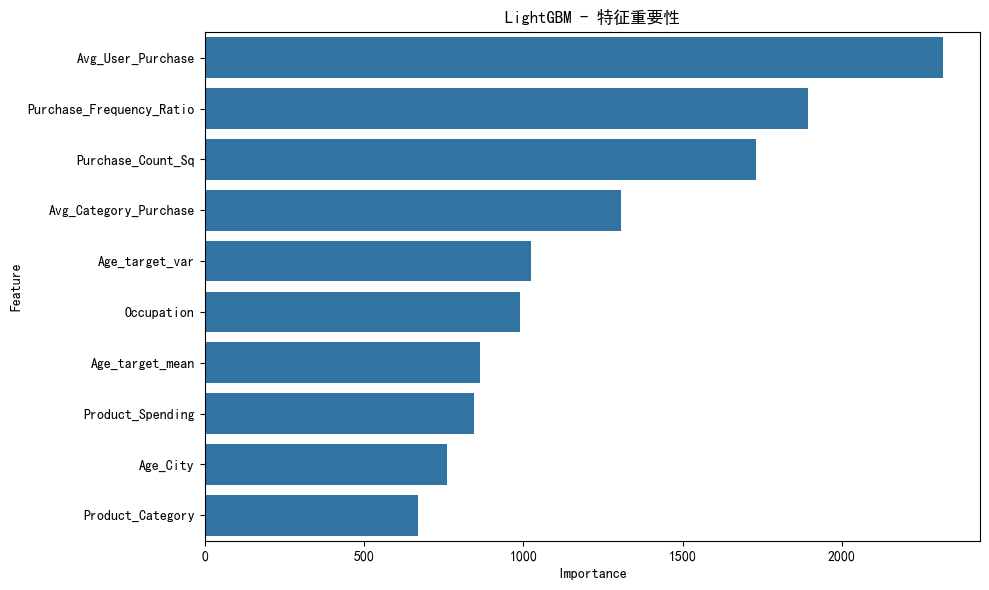

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['font.family'] = 'SimHei'  # 或其他支持中文的字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

# 获取特征重要性
feature_importance = pd.DataFrame({
    'Feature': top_features,
    'Importance': best_lgbm.feature_importances_
}).sort_values('Importance', ascending=False)

# 创建输出目录
os.makedirs('../outputs/visualization/lgbm', exist_ok=True)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('LightGBM - 特征重要性')
plt.tight_layout()
plt.savefig('../outputs/visualization/lgbm/feature_importance_lgbm.png')
plt.show()

# 4--番外 Ridge模型简化

In [29]:
from sklearn.linear_model import Ridge

print("训练简化版Ridge模型(基于前10大特征)...")

ridge_model = Ridge(alpha=1.0, random_state=42)
start_time = time.time()
ridge_model.fit(X_train_slim, y_train)
ridge_train_time = time.time() - start_time

# 评估Ridge模型
y_pred_ridge = ridge_model.predict(X_test_slim)
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print("简化Ridge模型评估结果:")
print(f"  R²: {r2_ridge:.4f}")
print(f"  RMSE: {rmse_ridge:.2f}")
print(f"  MAE: {mae_ridge:.2f}")
print(f"  训练时间: {ridge_train_time:.2f}秒")

训练简化版Ridge模型(基于前10大特征)...
简化Ridge模型评估结果:
  R²: 0.6585
  RMSE: 2929.05
  MAE: 2194.64
  训练时间: 0.09秒


# 5 其他模型

## 5.1 XGBoost

In [35]:
import xgboost as xgb

# 创建高度优化的XGBoost模型
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1正则化
    reg_lambda=1.0,  # L2正则化
    tree_method='hist',  # 更快的训练方法
    random_state=42,
    n_jobs=-1
)

# 使用简化特征集训练
xgb_model.fit(X_train_slim, y_train)

# 评估
y_pred_xgb = xgb_model.predict(X_test_slim)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost: R² = {r2_xgb:.4f}, RMSE = {rmse_xgb:.2f}")

XGBoost: R² = 0.6723, RMSE = 2869.68


In [41]:
from sklearn.model_selection import RandomizedSearchCV

# 参数网格
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200, 400],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 1, 10, 100]
}

# 随机搜索
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(tree_method='hist', random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=20,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_slim, y_train)
print("最佳参数:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\avawa\.conda\envs\mixrec\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
9 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\avawa\.conda\envs\mixrec\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\avawa\.conda\envs\mixrec\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\avawa\.conda\envs\mixrec\lib\site-packages\xgboost\sklearn.py", line 1143, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "c:\User

最佳参数: {'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 10, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [43]:
# 使用最佳参数重新训练XGBoost模型
best_xgb_params = random_search.best_params_  # 从微调中获取最佳参数

xgb_model = xgb.XGBRegressor(
    **best_xgb_params,  # 使用最佳参数
    tree_method='hist',  # 更快的训练方法
    random_state=42,
    n_jobs=-1
)

# 训练模型
print("使用最佳参数训练XGBoost模型...")
start_time = time.time()
xgb_model.fit(X_train_slim, y_train)
train_time = time.time() - start_time

# 评估模型
y_pred_xgb = xgb_model.predict(X_test_slim)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost模型评估结果 (使用最佳参数):")
print(f"  R²: {r2_xgb:.4f}")
print(f"  RMSE: {rmse_xgb:.2f}")
print(f"  MAE: {mae_xgb:.2f}")
print(f"  训练时间: {train_time:.2f}秒")

使用最佳参数训练XGBoost模型...


c:\Users\avawa\.conda\envs\mixrec\lib\site-packages\xgboost\core.py:158: UserWarning: [13:43:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bagging_temperature", "depth", "iterations", "l2_leaf_reg" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost模型评估结果 (使用最佳参数):
  R²: 0.6714
  RMSE: 2873.50
  MAE: 2124.02
  训练时间: 0.77秒


## 5.2 CatBoost

In [37]:
from catboost import CatBoostRegressor

# 确定分类特征索引
categorical_features_indices = [i for i, feature in enumerate(top_features) if feature in ['Age_City', 'Gender_Marital', 'City_Category']]

# 创建CatBoost模型
cat_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    loss_function='RMSE',
    random_seed=42,
    verbose=0
)

# 训练时指定分类特征
cat_model.fit(X_train_slim, y_train, cat_features=categorical_features_indices)

# 评估
y_pred_cat = cat_model.predict(X_test_slim)
r2_cat = r2_score(y_test, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
print(f"CatBoost: R² = {r2_cat:.4f}, RMSE = {rmse_cat:.2f}")

CatBoost: R² = 0.6696, RMSE = 2881.37


In [42]:
from sklearn.model_selection import RandomizedSearchCV

# 参数网格
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'iterations': [100, 200, 500],
    'l2_leaf_reg': [1, 3, 5, 10],
    'bagging_temperature': [0, 1, 3, 5]
}

# 随机搜索
random_search = RandomizedSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_seed=42),
    param_distributions=param_grid,
    n_iter=20,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_slim, y_train)
print("最佳参数:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳参数: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 10, 'bagging_temperature': 1}


In [44]:
# 使用最佳参数重新训练CatBoost模型
best_cat_params = random_search.best_params_  # 从微调中获取最佳参数

cat_model = CatBoostRegressor(
    **best_cat_params,  # 使用最佳参数
    random_seed=42,
    verbose=0  # 关闭训练过程中的详细输出
)

# 训练模型
print("使用最佳参数训练CatBoost模型...")
start_time = time.time()
cat_model.fit(X_train_slim, y_train, cat_features=categorical_features_indices)
train_time = time.time() - start_time

# 评估模型
y_pred_cat = cat_model.predict(X_test_slim)
r2_cat = r2_score(y_test, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
mae_cat = mean_absolute_error(y_test, y_pred_cat)

print(f"CatBoost模型评估结果 (使用最佳参数):")
print(f"  R²: {r2_cat:.4f}")
print(f"  RMSE: {rmse_cat:.2f}")
print(f"  MAE: {mae_cat:.2f}")
print(f"  训练时间: {train_time:.2f}秒")

使用最佳参数训练CatBoost模型...
CatBoost模型评估结果 (使用最佳参数):
  R²: 0.6786
  RMSE: 2841.97
  MAE: 2096.47
  训练时间: 72.11秒


# 6 Voting & Blending

In [51]:
from sklearn.ensemble import VotingRegressor

# 创建投票回归器
voting_regressor = VotingRegressor(
    estimators=[
        ('lgbm', best_lgbm),
        ('xgb', xgb_model),
        ('cat', cat_model)
    ]
)

# 训练投票回归器
voting_regressor.fit(X_train_slim, y_train)

# 评估投票回归器
y_pred_voting = voting_regressor.predict(X_test_slim)
r2_voting = r2_score(y_test, y_pred_voting)
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting))
mae_voting = mean_absolute_error(y_test, y_pred_voting)

print(f"Voting Regressor: R² = {r2_voting:.4f}, RMSE = {rmse_voting:.2f}, MAE = {mae_voting:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 440054, number of used features: 10
[LightGBM] [Info] Start training from score 9266.733955


c:\Users\avawa\.conda\envs\mixrec\lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bagging_temperature", "depth", "iterations", "l2_leaf_reg" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Regressor: R² = 0.6788, RMSE = 2840.92, MAE = 2096.28


In [52]:
# 手动Blending
y_blend = 0.8 * y_pred_lgbm + 0.05 * y_pred_xgb + 0.15 * y_pred_cat

# 评估Blending模型
r2_blend = r2_score(y_test, y_blend)
rmse_blend = np.sqrt(mean_squared_error(y_test, y_blend))
mae_blend = mean_absolute_error(y_test, y_blend)

print(f"Blending模型: R² = {r2_blend:.4f}, RMSE = {rmse_blend:.2f}, MAE = {mae_blend:.2f}")

Blending模型: R² = 0.6812, RMSE = 2830.21, MAE = 2085.56
